<a href="https://colab.research.google.com/github/koiralakp5/AFM_Krishna/blob/main/sliding_window.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pysptools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysptools: filename=pysptools-0.15.0-py3-none-any.whl size=8133736 sha256=26a0392c7f089b15274bd1765028ef890f3f0e068f270ba78adb6db625f3f779
  Stored in directory: /root/.cache/pip/wheels/ea/08/3b/c045ea3722a5fef1f8698f060a17b59140235fef580fe4f1b5
Successfully built pysptools


In [11]:
from google.colab import files
uploaded = files.upload()

Saving LFO_STO11_Crop.jpg to LFO_STO11_Crop.jpg


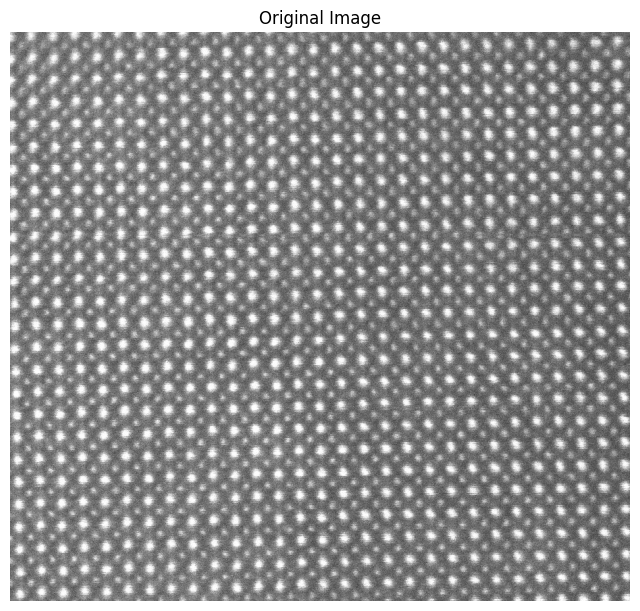

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fft import fft2, fftshift
from pysptools.eea import NFINDR
from sklearn.decomposition import PCA
from skimage import data

# Load an image
from skimage import data
import skimage as ski

image = ski.io.imread('LFO_STO11_Crop.jpg')
# Display the original image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [16]:
if image.ndim == 3:
    image = image[:, :, 0]

In [17]:
def sliding_window_fft(image, window_size):
    rows, cols = image.shape
    half_window = window_size // 2
    padded_image = np.pad(image, half_window, mode='reflect')

    fft_results = np.zeros((rows, cols, window_size, window_size), dtype=complex)
    for i in range(rows):
        for j in range(cols):
            window = padded_image[i:i + window_size, j:j + window_size]
            fft_results[i, j] = fftshift(fft2(window))

    return fft_results

In [18]:
window_size = 16  # Example window size
fft_results = sliding_window_fft(image, window_size)

In [36]:
# Flatten the FFT results and take the magnitude
fft_magnitude = np.log(np.abs(fft_results) + 1)

# Reshape to 2D: (number of samples, number of features)
num_samples = fft_magnitude.shape[0] * fft_magnitude.shape[1]
num_features = fft_magnitude.shape[2] * fft_magnitude.shape[3]
fft_magnitude_reshaped = fft_magnitude.reshape(num_samples, num_features)

pca = PCA(n_components=2)  # Number of principal components to keep
pca_result = pca.fit_transform(fft_magnitude_reshaped)

# If you need to reshape PCA results back to image format,
# you'll need to determine the appropriate shape based
# on your original image dimensions and how you want to
# visualize the PCA components.

In [37]:
# Reshape FFT results to a 3D array (samples, rows, cols)
fft_magnitude_3d = fft_magnitude.reshape(fft_magnitude.shape[0], fft_magnitude.shape[1], -1)

n_endmembers = 2  # Number of endmembers to extract
nfindr = NFINDR()
endmembers = nfindr.extract(fft_magnitude_3d, n_endmembers)  # Pass the 3D array

print("Extracted endmembers:")
print(endmembers)

Extracted endmembers:
[[ 2.7080503  5.6475005  4.9512663  4.656932   4.6663504  5.593218
   6.126142   6.604965   6.8638034  6.604965   6.126142   5.593218
   4.6663504  4.656932   4.9512663  5.6475005  5.632621   5.1987433
   5.466553   4.6553683  5.4602385  5.5141463  5.7070017  5.9932394
   6.42125    6.1948886  5.5203815  5.8611956  6.2696238  5.640569
   5.0535364  5.748469   4.9111423  5.241624   5.3539567  5.6800113
   5.917457   6.1483593  5.869694   6.2544785  5.4824853  6.3176785
   6.309273   6.1218824  5.8235765  4.8014665  5.2267394  5.8749213
   5.4196444  6.419477   5.863995   6.1029215  4.9771495  6.199159
   5.9914184  6.7433953  6.835597   6.5360136  5.8413687  5.6310635
   5.90839    5.3699703  5.699988   4.1290507  5.332789   5.589907
   5.0108147  4.99391    4.856531   5.258723   5.6022067  5.893539
   6.2271957  6.0769424  4.311596   5.216129   4.2042403  4.810399
   5.877465   4.709186   5.151768   5.27873    5.5298624  5.249599
   6.040575   5.9134684  5.8459563

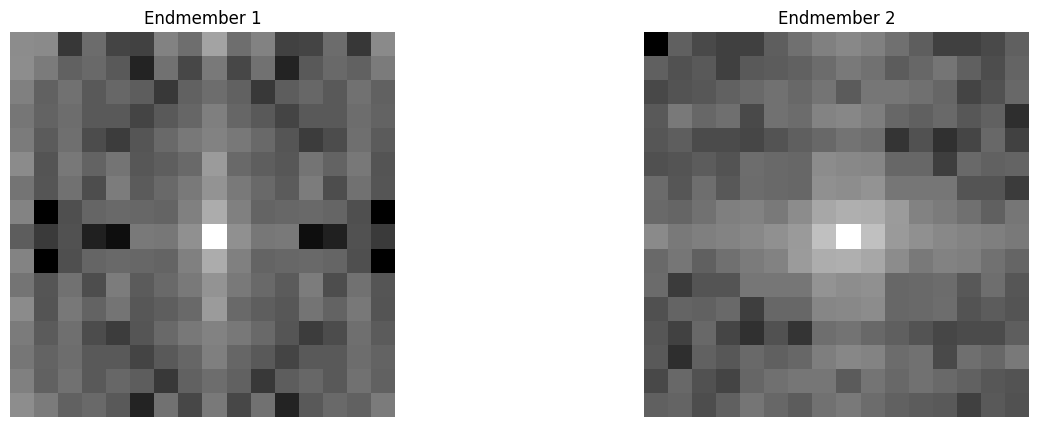

In [31]:
plt.figure(figsize=(15, 5))
for i, endmember in enumerate(endmembers):
    plt.subplot(1, n_endmembers, i + 1)
    plt.title(f'Endmember {i + 1}')
    plt.imshow(endmember.reshape(window_size, window_size), cmap='gray')
    plt.axis('off')
plt.show()

In [34]:
def compute_abundances(pca_result_reshaped, endmembers):
    num_rows, num_cols, num_features = pca_result_reshaped.shape
    num_endmembers = endmembers.shape[0]
    abundances = np.zeros((num_rows, num_cols, num_endmembers))

    for i in range(num_rows):
        for j in range(num_cols):
            pixel = pca_result_reshaped[i, j]
            for k in range(num_endmembers):
                # Transpose endmembers[k] to align dimensions for dot product
                abundances[i, j, k] = np.dot(pixel, endmembers[k].T) / np.linalg.norm(endmembers[k])

    return abundances

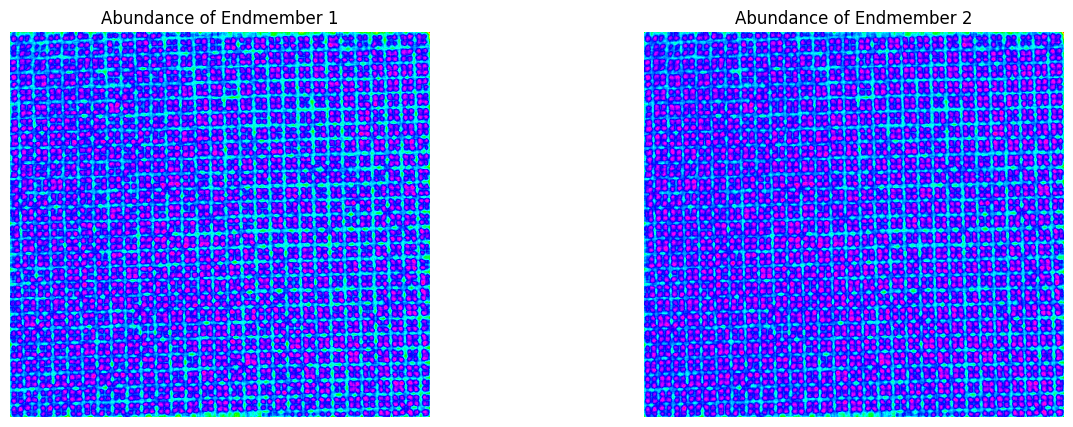

In [35]:
plt.figure(figsize=(15, 5))
for i in range(n_endmembers):
    plt.subplot(1, n_endmembers, i + 1)
    plt.title(f'Abundance of Endmember {i + 1}')
    plt.imshow(abundances[:, :, i], cmap='hsv')
    plt.axis('off')
plt.show()